In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from scipy.stats import shapiro, normaltest

In [13]:
file_path = "PlanilhaCompleta.xlsx"

data = pd.read_excel(file_path)

In [14]:
# Substituindo os valores da coluna 'Ploidia' de 'euploide' e 'aneuploide' para 0 e 1
data['Ploidia'] = data['Ploidia'].replace({'Euplóide': 0, 'Aneuplóide': 1})

# Verificando os primeiros valores da coluna 'Ploidia' após a alteração
#print(data['Ploidia'].head())

/tmp/ipykernel_6615/884588328.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Ploidia'] = data['Ploidia'].replace({'Euplóide': 0, 'Aneuplóide': 1})


In [15]:
data['Estágio'] = data['Estágio'].str.replace("D", "", regex=False)
data['Estágio'] = pd.to_numeric(data['Estágio'], errors='coerce')

# Verifique os primeiros valores após a alteração
print(data['Estágio'].head(20))

0     5
1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    6
11    6
12    5
13    6
14    5
15    5
16    5
17    5
18    6
19    5
Name: Estágio, dtype: int64


In [5]:
def classificar_morfo(valor):
    prefixo = valor[0]
    sufixo = valor[1:]

    if sufixo == "AA" and prefixo in "3456":
        return 1  # Excelente
    elif sufixo in ["AB", "BA"] and prefixo in "3456":
        return 2  # Bom
    elif sufixo in ["BB", "AC", "CA"] and prefixo in "3456":
        return 3  # Médio
    else:
        return 4  # Ruim

# Aplicar a função
data['MorfoGrupo'] = data['Morfo'].apply(classificar_morfo)

# Substituir a coluna original
data['Morfo'] = data['MorfoGrupo']

# Verificação
print(data[['MorfoGrupo']].value_counts())

MorfoGrupo
3             25
4             23
2             17
1             17
Name: count, dtype: int64


In [6]:
numerical_columns = [
    "Idade", "Estágio", "Morfo", "Kidscore", "t2", "t3", "t4", "t5", "t8", "tSC", "tSB", "tB",
    "cc2 (t3-t2)", "cc3 (t5-t3)", "t5-t2", "s2 (t4-t3)", "s3 (t8-t5)", "tSC-t8", "tB-tSB", "Ploidia",
]

A ideia é simular o comportamento estatístico de cada variável se ela fosse medida milhares de vezes, assumindo que os dados seguem uma distribuição normal com os parâmetros (média e desvio padrão) observados.

In [7]:
dados = {}

print("Variável\t\tMédia\t\tDesvio Padrão")
print("-" * 50)
for col in numerical_columns:
    media = data[col].mean()
    desvio = data[col].std()
    dados[col] = (media, desvio)
    print(f"{col:20s} {media:.4f}\t\t{desvio:.4f}")

N = 1000 #Cria 10.000 amostras para cada variável, assumindo que seguem distribuição normal com os parâmetros calculados anteriormente.

# Gerar amostras para cada variável
np.random.seed(0)
samples = {
    var: np.random.normal(loc=media, scale=desvio, size=N)
    for var, (media, desvio) in dados.items()
}

# Fórmulas derivadas (com base nos nomes da sua planilha)
cc2 = samples['t3'] - samples['t2']
cc3 = samples['t5'] - samples['t3']
t5_t2 = samples['t5'] - samples['t2']
s2 = samples['t4'] - samples['t3']
s3 = samples['t8'] - samples['t5']
tSC_t8 = samples['tSC'] - samples['t8']
tB_tSB = samples['tB'] - samples['tSB']
kidscore = samples['Kidscore']
ploidia = samples['Ploidia']
estagio = samples['Estágio']
morfo = samples['Morfo']

# Guardando tudo para plotagem
derivadas = {
    'cc2 (t3 - t2)': cc2,
    'cc3 (t5 - t3)': cc3,
    't5 - t2': t5_t2,
    's2 (t4 - t3)': s2,
    's3 (t8 - t5)': s3,
    'tSC - t8': tSC_t8,
    'tB - tSB': tB_tSB,
    'Kidscore': kidscore,
    'Ploidia': ploidia,
    'Estágio': estagio,
    'Morfo': morfo
}


Variável		Média		Desvio Padrão
--------------------------------------------------
Idade                39.0854		3.2364
Estágio              5.1707		0.4099
Morfo                2.6585		1.1024
Kidscore             5.6354		2.0307
t2                   25.2793		2.6639
t3                   35.8122		4.4250
t4                   37.2707		3.4480
t5                   46.8573		7.1245
t8                   55.6476		8.1358
tSC                  89.5854		10.1313
tSB                  101.3878		9.5908
tB                   110.3061		10.7077
cc2 (t3-t2)          10.5329		3.0192
cc3 (t5-t3)          11.0451		5.0253
t5-t2                21.5780		6.0784
s2 (t4-t3)           1.4585		2.8048
s3 (t8-t5)           8.7902		7.9125
tSC-t8               33.9378		10.4585
tB-tSB               8.9183		3.8817
Ploidia              0.5000		0.5031


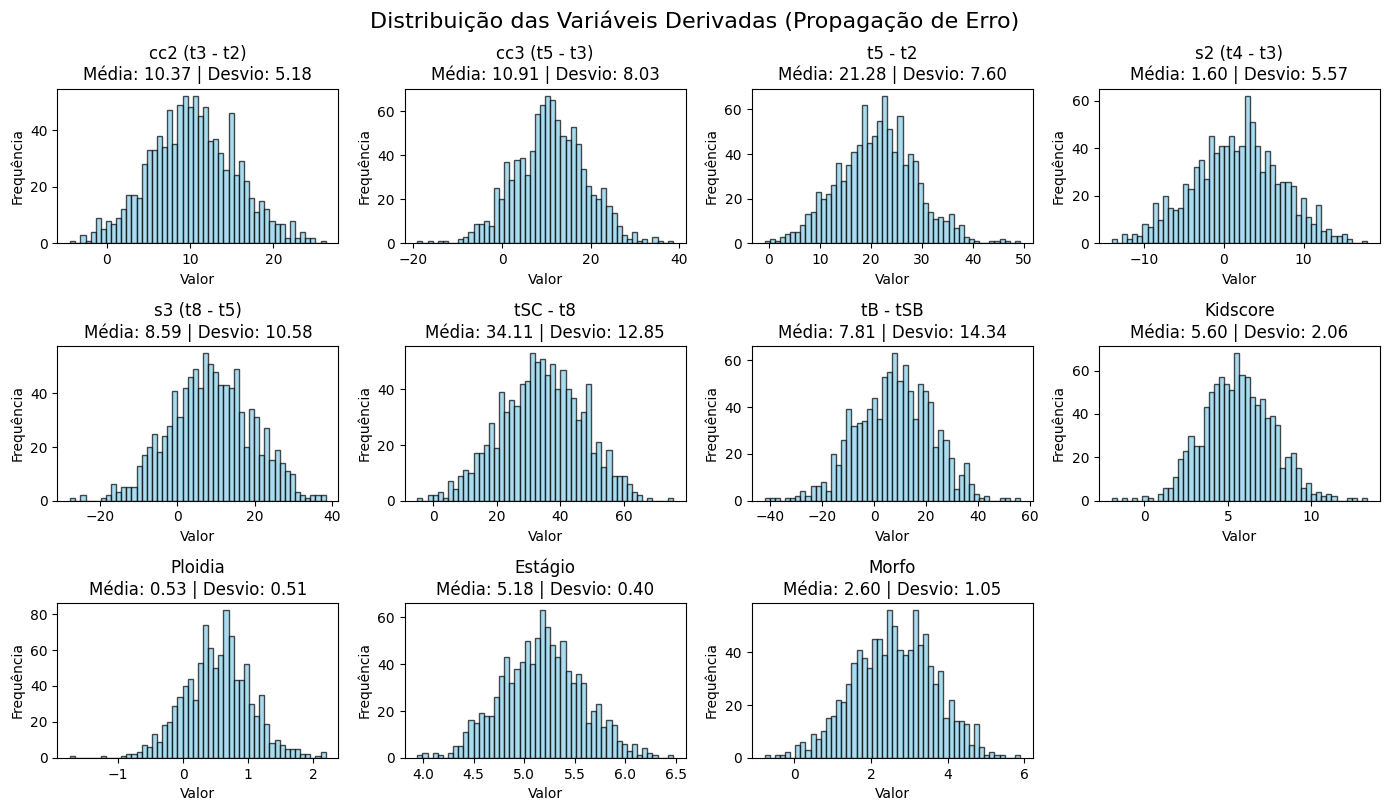

In [8]:
# Gerando os gráficos de propagação de erro
plt.figure(figsize=(14, 10))
for i, (nome, valores) in enumerate(derivadas.items(), 1):
    plt.subplot(4, 4, i)
    plt.hist(valores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'{nome}\nMédia: {np.mean(valores):.2f} | Desvio: {np.std(valores):.2f}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.suptitle('Distribuição das Variáveis Derivadas (Propagação de Erro)', fontsize=16, y=1.02)
plt.show()


A **assimetria** mede se a distribuição tem uma cauda maior de um lado. Valores típicos:
| Skew | Interpretação        | Forma                  |
|------|----------------------|------------------------|
| 0    | Simétrica (normal)   | Bell curve             |
| > 0  | Assimetria à direita | Cauda longa à direita |
| < 0  | Assimetria à esquerda| Cauda longa à esquerda|

A **curtose** mede o "achatamento" ou "pico" da curva.
| Curtose | Interpretação | Forma                         |
|---------|----------------|-------------------------------|
| 0       | Normal         | Curva média                   |
| > 0     | Leptocúrtica   | Pico mais alto, caudas pesadas |
| < 0     | Platicúrtica   | Pico mais achatado, caudas leves |

O **gráfico Q-Q Plot (Quantile-Quantile Plot)** compara os quantis da sua amostra simulada com os quantis de uma distribuição normal teórica.

- Se os pontos estiverem alinhados com a linha diagonal, a variável está bem próxima de uma distribuição normal.
- Se os pontos saírem da linha nos extremos (caudas), a variável pode ter:
    - Assimetria (skew)
    - Curtose diferente da normal
    - Outliers
- Ele serve como uma validação visual dos testes de normalidade.

cc2 (t3 - t2):
  Assimetria: 0.1020
  Curtose: -0.1049
----------------------------------------
cc3 (t5 - t3):
  Assimetria: -0.0006
  Curtose: 0.2118
----------------------------------------
t5 - t2:
  Assimetria: 0.1034
  Curtose: 0.1687
----------------------------------------
s2 (t4 - t3):
  Assimetria: -0.0528
  Curtose: -0.2644
----------------------------------------
s3 (t8 - t5):
  Assimetria: -0.0455
  Curtose: -0.1736
----------------------------------------
tSC - t8:
  Assimetria: -0.0796
  Curtose: -0.2856
----------------------------------------
tB - tSB:
  Assimetria: -0.1041
  Curtose: -0.0243
----------------------------------------
Kidscore:
  Assimetria: 0.1157
  Curtose: 0.1954
----------------------------------------
Ploidia:
  Assimetria: -0.0289
  Curtose: 0.4614
----------------------------------------
Estágio:
  Assimetria: 0.0556
  Curtose: -0.1075
----------------------------------------
Morfo:
  Assimetria: -0.0793
  Curtose: -0.2472
-------------------------

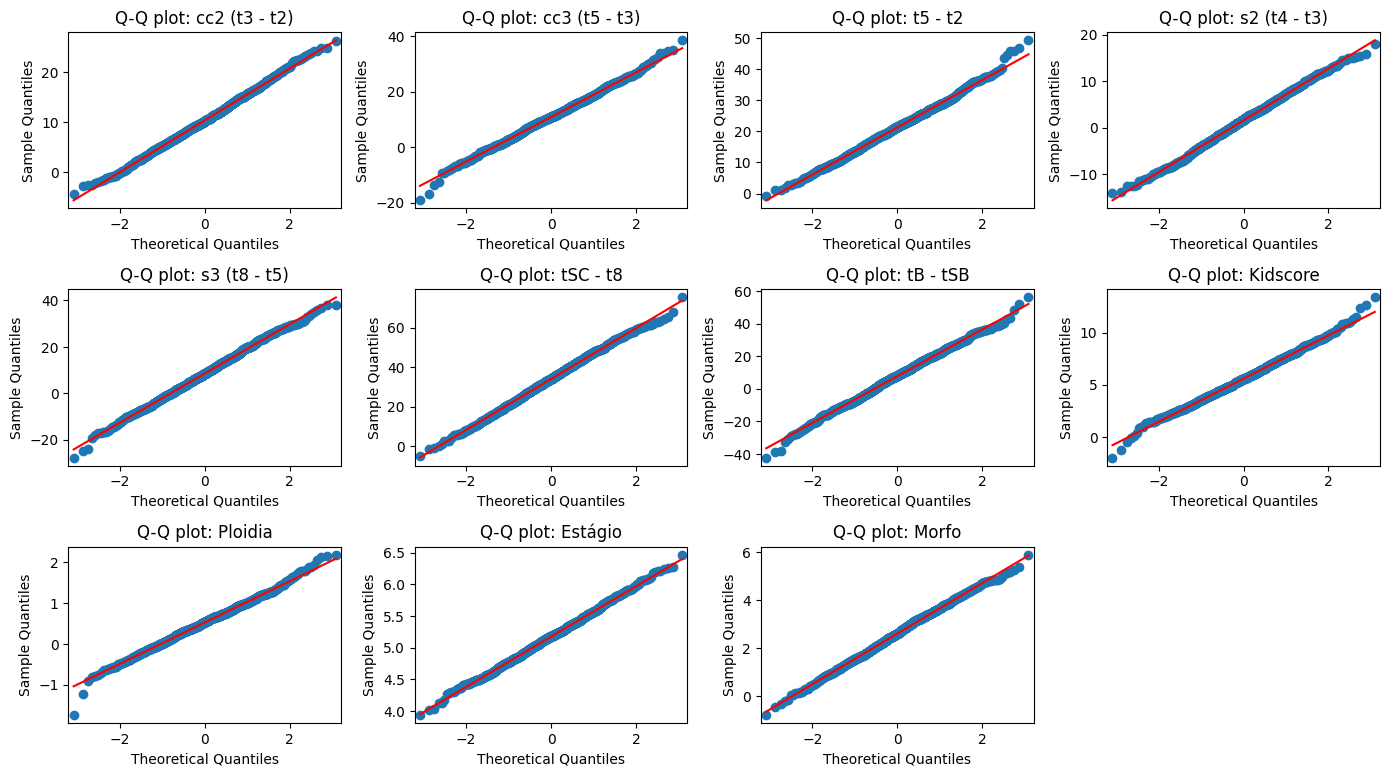

In [10]:
# Gráficos Q-Q
for nome, valores in derivadas.items():
    print(f"{nome}:")
    print(f"  Assimetria: {skew(valores):.4f}")
    print(f"  Curtose: {kurtosis(valores):.4f}")
    print("-" * 40)

plt.figure(figsize=(14, 10))
for i, (nome, valores) in enumerate(derivadas.items(), 1):
    plt.subplot(4, 4, i)
    sm.qqplot(valores, line='s', ax=plt.gca())
    plt.title(f'Q-Q plot: {nome}')

plt.tight_layout()
plt.show()

In [11]:
for nome, valores in derivadas.items():
    stat, p = shapiro(valores)
    print(f"{nome}:")
    print(f"  Shapiro-Wilk p-value: {p:.4f}")
    
    stat, p = normaltest(valores)
    print(f"  D'Agostino-Pearson p-value: {p:.4f}")
    print("-" * 40)

cc2 (t3 - t2):
  Shapiro-Wilk p-value: 0.3483
  D'Agostino-Pearson p-value: 0.3468
----------------------------------------
cc3 (t5 - t3):
  Shapiro-Wilk p-value: 0.5398
  D'Agostino-Pearson p-value: 0.3926
----------------------------------------
t5 - t2:
  Shapiro-Wilk p-value: 0.1063
  D'Agostino-Pearson p-value: 0.2144
----------------------------------------
s2 (t4 - t3):
  Shapiro-Wilk p-value: 0.1924
  D'Agostino-Pearson p-value: 0.1369
----------------------------------------
s3 (t8 - t5):
  Shapiro-Wilk p-value: 0.4857
  D'Agostino-Pearson p-value: 0.4461
----------------------------------------
tSC - t8:
  Shapiro-Wilk p-value: 0.2806
  D'Agostino-Pearson p-value: 0.0704
----------------------------------------
tB - tSB:
  Shapiro-Wilk p-value: 0.3296
  D'Agostino-Pearson p-value: 0.4015
----------------------------------------
Kidscore:
  Shapiro-Wilk p-value: 0.2450
  D'Agostino-Pearson p-value: 0.1433
----------------------------------------
Ploidia:
  Shapiro-Wilk p-value

### Conclusão
Todas as variáveis analisadas apresentam:
- Q-Q plots alinhados com a normal
- Assimetria e curtose próximas de zero
- Testes de normalidade com p > 0.05

Portanto, pode-se assumir que todas essas variáveis seguem uma distribuição normal.